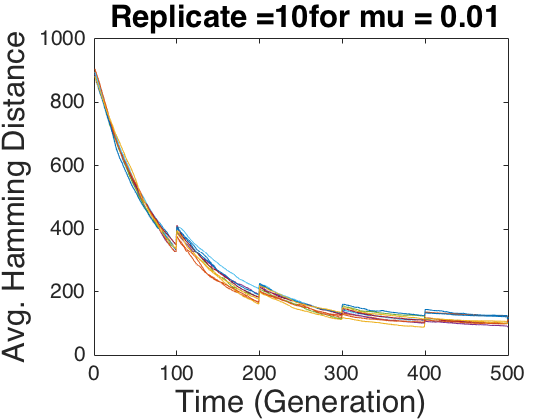

In [1]:
%General Parameters
N = 1000; %population size
num_loci = 1000;%number of loci in accessory genome
m = [100]; %m = [1, 10,50, 100, 1000, 10000];
mu_1 =  10^(-2);%mutation rate
rev_mut = .001;
num_essential = round(.25*num_loci);

%scalar values of some things
s_baggage = .01;%costs
s_gains = .1;%weights
frac_needed_scalar = .1; %fraction_needed
alpha= 1.96;
%vector values of the same things things
% weights = .1 * ones(1, num_loci);%vector of length "num_loci" denoting fitness contribution
%             %of each functional locus when needed
% costs = .001 * ones(1, num_loci);%vector denoting fitness cost of functional loci when not needed
% fraction_needed = .1 * ones(1, num_loci);%vector denoting fraction of environments each locus is needed


%simulation parameters
num_reps = 10; %number of replicate runs
time = 5*m;
%initialize data structures
avg_hamming_dist = nan(num_reps,time);
m_array_index = 0;





%for the figure
close all;
figure(1);
fontSize = 15;






change_rate = m;%number of gens btwn environmental changes


for j = 1:num_reps
    pop = [N,ones(1,num_loci),mu_1]; %starts all individuals with all functional loci
    rand_vect = rand(1,num_loci); %initializes with a random environment
    env = rand_vect<=frac_needed_scalar;
    k=1;
    counter = 0;
    avg_hamming_dist(j,1) = sum(pop(:,2:end-1) ~= repmat(env, [length(pop(:,1)) 1]),2);
    point_in_time = 0;
    
    while k == 1
        
        counter = counter + 1;
        point_in_time = point_in_time + 1;
        if mod(counter,change_rate)==0 %determines if environment should change this generation
            rand_vect = rand(1,num_loci); %initializes with a random environment
            env = rand_vect<=frac_needed_scalar; %resets each environment
        end
        
        pop = mutate3(pop, rev_mut, num_essential); %mutate population
        %%%%%%%%%%% deals with extinction %%%%%%%%%%%%%%%%%%%
        if (size(pop,1) == 1) && (isnan(pop(:,2)))
            break
        end
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        
        fitnesses = compute_fitness3(pop,s_gains,env,s_baggage); %computes fitnesses for each unique genotype
        
        pop = wright_fisher2(fitnesses); %performs wright_fisher sampling to update population to next generation
        avg_hamming_dist(j,point_in_time) = mean(sum(pop(:,2:end-1) ~= repmat(env, [length(pop(:,1)) 1]),2));
        
        
        
        if point_in_time == time
            k = 0;
        end
        
        
        
    end
    
    
end
x2=1:length(avg_hamming_dist);
y2=avg_hamming_dist;
plot(x2,y2)
a = [' Replicate =', num2str(num_reps),'for mu = ', num2str(mu_1),'' ];
title(a, 'FontSize', fontSize);
ylabel('Avg. Hamming Distance', 'FontSize', fontSize);
xlabel('Time (Generation)', 'FontSize', fontSize);


In [2]:
save('Hamming Distance PolyFit mu= 10^(-2).mat');

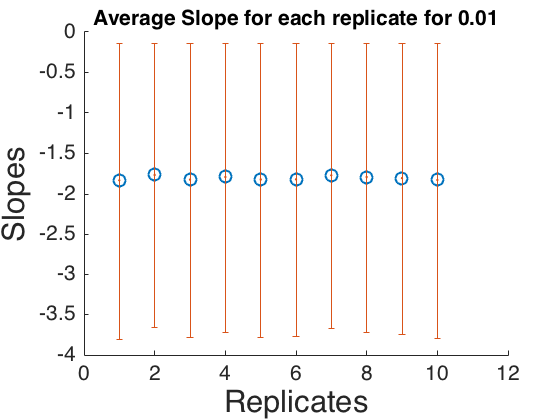

phat =

   -1.8309
   -1.7630
   -1.8214
   -1.7897
   -1.8209
   -1.8180
   -1.7692
   -1.7919
   -1.8048
   -1.8269


ci =

   -1.9720   -1.6898
   -1.8998   -1.6262
   -1.9619   -1.6809
   -1.9282   -1.6512
   -1.9613   -1.6804
   -1.9583   -1.6777
   -1.9064   -1.6321
   -1.9306   -1.6533
   -1.9442   -1.6653
   -1.9677   -1.6860

In [6]:
load('Hamming Distance PolyFit mu= 10^(-2).mat');
time = 5*m;
loci_array = zeros((time/m),(m-1),num_reps);
for z = 1:num_reps
    for j = 1:(time/m)
        for i = 1:(m-1)
            loci_array(j,i,z) = avg_hamming_dist(z, ((j-1)*m+i));
        end
    end
end

for z = 1:num_reps
    for j=1:(time/m)
        if j == 1
            eval(sprintf('x%dz%d = (((j-1)*m)+1):((j-1)*m + m-1);', j,z));
        else
            eval(sprintf('x%dz%d = ((j-1)*m):((j-1)*m + m-2);', j,z)); %in order to keep the indices  the same {199,299,399,499} are not included
        end
        eval(sprintf('y%dz%d = loci_array(j,:,z);', j,z));
        eval(sprintf('p%dz%d = polyfit(x%dz%d,y%dz%d, 1);', j,z,j,z,j,z));
        eval(sprintf('q%dz%d = polyder(p%dz%d);', j,z,j,z));
        eval(sprintf('f%dz%d = polyval(p%dz%d,x%dz%d);', j,z,j,z,j,z));
        eval(sprintf('yfit%dz%d = p%dz%d(1) * x%dz%d + p%dz%d(2);', j,z,j,z,j,z,j,z));
        %eval(sprintf('yfit%dz%d = p%dz%d(1) * x%dz%d + p%dz%d(2) * x%dz%d.^2 + p%dz%d(3) * x%dz%d + p%dz%d(4);', j,z));
        eval(sprintf('yresid%dz%d = y%dz%d - yfit%dz%d;', j,z,j,z,j,z));
        eval(sprintf('SSresid%dz%d = sum(yresid%dz%d.^2);', j,z,j,z));
        eval(sprintf('SStotal%dz%d = (length(y%dz%d)-1)* var(y%dz%d);', j,z,j,z,j,z));
        eval(sprintf('rsq%dz%d = 1 - SSresid%dz%d/SStotal%dz%d;', j,z,j,z,j,z));
        %eval(sprintf('rsq_adj%dz%d = 1 - SSresid%dz%d/SStotal%dz%d*(length(y%dz%d)-1)/(length(y%dz%d)-length(p%dz%d)); ', j,z));
        
    end
end

slopes = zeros(num_reps,(time/m));
rsq_matrix = zeros(num_reps,(time/m));

for z = 1:num_reps
    for j=1:(time/m)
    eval(sprintf('slopes(z,j) = q%dz%d;', j,z));  
    eval(sprintf('rsq_matrix(z,j) = rsq%dz%d;', j,z));    
    end
    eval(sprintf('slopes_r%d = sum(slopes(z,:),2)/(time/m);', z));
    eval(sprintf('rsq_r%d = sum(rsq_matrix(z,:),2)/(time/m);', z));
end


%slopes_r1 = sum(slopes(1,:),2)/(time/m);%slopes_r2 = sum(slopes(2,:),2)/(time/m);%slopes_r3 = sum(slopes(3,:),2)/(time/m);
%slopes_r4 = sum(slopes(4,:),2)/(time/m);%slopes_r5 = sum(slopes(5,:),2)/(time/m);%slopes_r6 = sum(slopes(6,:),2)/(time/m);
%slopes_r7 = sum(slopes(7,:),2)/(time/m);%slopes_r8 = sum(slopes(8,:),2)/(time/m);%slopes_r9 = sum(slopes(9,:),2)/(time/m);
%slopes_r10 = sum(slopes(10,:),2)/(time/m);
phat =[slopes_r1;slopes_r2; slopes_r3; slopes_r4;slopes_r5;slopes_r6; slopes_r7; slopes_r8;slopes_r9; slopes_r10]
se = sqrt((abs((1-phat).*(phat)))./N);
ci_plus = phat + alpha*se;
ci_minus = phat - alpha*se;
ci = [ci_minus, ci_plus]
figure
hold on;
scatter([1:length(slopes(:,1))],phat)
errorbar([1:length(slopes(:,1))],phat,ci_minus, ci_plus,'.')
a = [ 'Average Slope for each replicate for ', num2str(mu_1),'' ];
title(a, 'FontSize', 10);
xlabel('Replicates', 'FontSize', fontSize);
ylabel('Slopes', 'FontSize', fontSize);

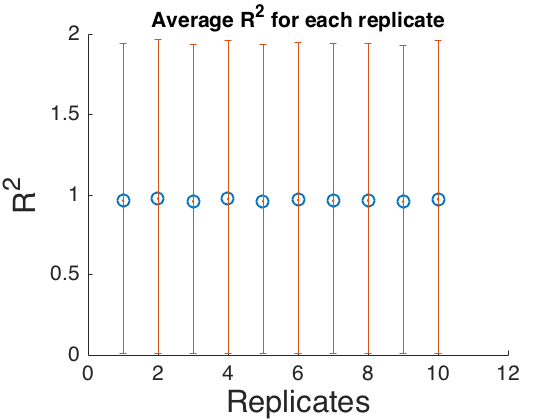

phat_rsq =

    0.9652
    0.9773
    0.9605
    0.9754
    0.9603
    0.9693
    0.9634
    0.9659
    0.9582
    0.9738


ci_rsq =

    0.9538    0.9766
    0.9681    0.9866
    0.9484    0.9725
    0.9658    0.9850
    0.9482    0.9724
    0.9586    0.9800
    0.9518    0.9751
    0.9546    0.9771
    0.9458    0.9706
    0.9639    0.9837

In [5]:
%rsq_r1 = sum(rsq_matrix(1,:),2)/(time/m);%rsq_r2 = sum(rsq_matrix(2,:),2)/(time/m);%rsq_r3 = sum(rsq_matrix(3,:),2)/(time/m);
%rsq_r4 = sum(rsq_matrix(4,:),2)/(time/m);%rsq_r5 = sum(rsq_matrix(5,:),2)/(time/m);%rsq_r6 = sum(rsq_matrix(6,:),2)/(time/m);
%rsq_r7 = sum(rsq_matrix(7,:),2)/(time/m);%rsq_r8 = sum(rsq_matrix(8,:),2)/(time/m);%rsq_r9 = sum(rsq_matrix(9,:),2)/(time/m);
%rsq_r10 = sum(rsq_matrix(10,:),2)/(time/m);
phat_rsq =[rsq_r1;rsq_r2; rsq_r3; rsq_r4;rsq_r5;rsq_r6; rsq_r7; rsq_r8;rsq_r9; rsq_r10]
se_rsq = sqrt((abs((1-phat_rsq).*(phat_rsq)))./N);
ci_plus_rsq = phat_rsq + alpha*se_rsq;
ci_minus_rsq = phat_rsq - alpha*se_rsq;
ci_rsq = [ci_minus_rsq, ci_plus_rsq]
figure
hold on;
scatter([1:length(rsq_matrix(:,1))],phat_rsq)
errorbar([1:length(rsq_matrix(:,1))],phat_rsq,ci_minus_rsq, ci_plus_rsq,'.')
a = [ 'Average R^{2} for each replicate for ', num2str(mu_1),''];
title(a, 'FontSize', 10);
xlabel('Replicates', 'FontSize', fontSize);
ylabel('R^{2}', 'FontSize', fontSize);

In [5]:
save('Hamming Distance PolyFit mu= 10^(-2) final.mat');